In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import os
import sys
sys.path.append('/home/vaschetti/maxarSrc/datasets_and_samplers')
from myGeoDatasets import Maxar
from mySamplers import MyGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
from samplers_utils import boundingBox_2_Polygon
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import supervision as sv
import torch
from time import time


In [2]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031213.tif')
size = 608
sampler = MyGridGeoSampler(dataset, size=size, stride=size)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
data_crs = dataset.crs

#sys.path.append('/home/vaschetti/maxarSrc/creating_labels/MSBuildings')
from build_seg_utils import building_gdf
gdfs_32628 = building_gdf('TheGambia', dataset_crs = data_crs)
index_MS_buildings = gdfs_32628.sindex

Found 6 links for TheGambia


In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))
In plot
Crs EPSG:32628
sx_low:  (317998.046875, 1489843.75)
dx_high:  (318183.59375, 1490029.296875)


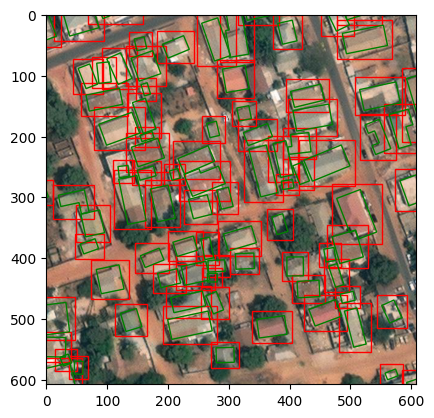

In [3]:
from random import randint
from build_seg_utils import rel_bbox_coords, rel_polyg_coord
dataset_res = dataset.res
i = 0
for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    hits = index_MS_buildings.query(query_bbox_poly)
    if len(hits) > 10: #per prendere immagini con almeno X edifici
        i+=1
        if i == 10 :#randint(0, 20): #per prendere immagini random
            sample = unbind_samples(batch)[0]
            img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
            
            #predictor.set_image(img4Sam) #encoding the image

            #Getting the relative coordinates of the buildings boxes
            building_boxes = rel_bbox_coords(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res, ext_mt=5)

            #Plotting
            fig, ax = dataset.plot(sample)   
            for box in building_boxes:
                x0, y0 = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
                ax.add_patch(rect)
            for rel_pol in rel_polyg_coord(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res):
                poly = patches.Polygon(rel_pol, linewidth=1, edgecolor='g', facecolor='none')
                ax.add_patch(poly)

            break

In [4]:
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/models/EfficientSAM')
from efficient_sam.efficient_sam import build_efficient_sam
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Build the model.
device = 'cpu'
ESAM_root = '/home/vaschetti/maxarSrc/creating_labels/models/EfficientSAM'
efficient_sam = build_efficient_sam(os.path.join(ESAM_root, 'weights/efficient_sam_vitt.pth'), device=device)
efficient_sam.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (proj): Linear(in_features=192, out_features=192, bias=True)
        )
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=768, out_features=192, bias=True)
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )
  )
  (pro

In [6]:
# load an image

sample_image_np = img4Sam
sample_image_tensor = transforms.ToTensor()(sample_image_np)
sample_image_tensor = sample_image_tensor.to(device)

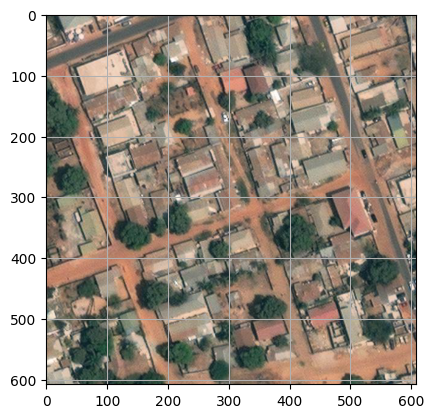

In [7]:
plt.imshow(sample_image_np)
plt.grid(True)
plt.show()

In [8]:
t_build_boxes = torch.tensor(building_boxes, device=device)
print('building boxes:', t_build_boxes.shape)
ESAM_boxes = t_build_boxes.unsqueeze(0)
ESAM_boxes = ESAM_boxes.reshape(-1,2,2)
print('ESAM_boxes:', ESAM_boxes.shape)

building boxes: torch.Size([86, 4])
ESAM_boxes: torch.Size([86, 2, 2])


In [9]:
input_points = ESAM_boxes.unsqueeze(0) #[B, max_num_queries, num_pts, 2] = [B, #boxes, 2, 2] unsqueeze to add the batch dim
input_labels = torch.tensor([[[2,3]]*input_points.shape[1]], device=device) #[B, max_num_queries, num_pts]

print(input_points.shape)
print(input_labels.shape)

torch.Size([1, 86, 2, 2])
torch.Size([1, 86, 2])


In [10]:
t0 = time()
predicted_logits, predicted_iou = efficient_sam(
    sample_image_tensor[None, ...],
    input_points,
    input_labels,
)
print('Time:', time() - t0)

Time: 5.1903040409088135


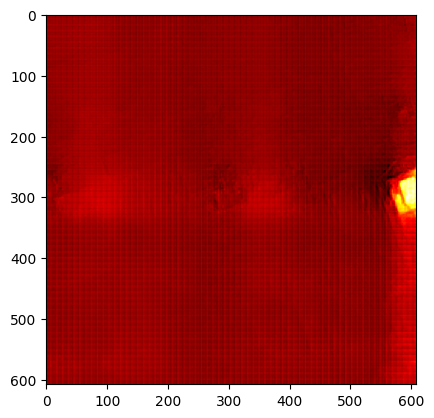

In [11]:
import matplotlib.pyplot as plt

# Assuming 'tensor' is your tensor
tensor_np = predicted_logits[0,1,0].cpu().detach().numpy()

plt.imshow(tensor_np, cmap='hot', interpolation='nearest')
plt.show()

Mask: torch.Size([1, 86, 3, 608, 608])


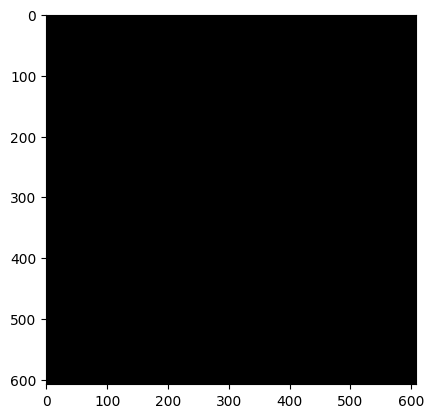

In [12]:
# The masks are already sorted by their predicted IOUs.
# The first dimension is the batch size (we have a single image. so it is 1).
# The second dimension is the number of masks we want to generate (in this case, it is only 1)
# The third dimension is the number of candidate masks output by the model.
# For this demo we use the first mask.
mask_ix = 0
mask = torch.ge(predicted_logits[0, mask_ix, 0, :, :], 0).cpu().detach().numpy()

masked_image_np = sample_image_np.copy().astype(np.uint8) * mask[:,:,None]

print('Mask:', predicted_logits.shape)
plt.imshow(masked_image_np)
#Image.fromarray(masked_image_np).save("figs/examples/dogs_efficient_sam_mask.png")

Mask: torch.Size([1, 86, 3, 608, 608])


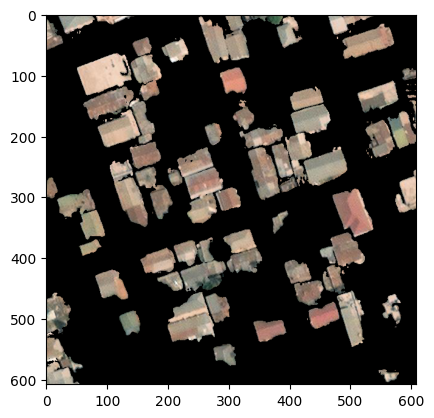

In [13]:
# The masks are already sorted by their predicted IOUs.
# The first dimension is the batch size (we have a single image. so it is 1).
# The second dimension is the number of masks we want to generate (in this case, it is only 1)
# The third dimension is the number of candidate masks output by the model.
# For this demo we use the first mask.
mask = torch.ge(predicted_logits[0, :, 0], 0).cpu().detach().numpy().any(axis=0)

masked_image_np = sample_image_np.copy().astype(np.uint8) * mask[:,:,None]

print('Mask:', predicted_logits.shape)
plt.imshow(masked_image_np)

In [14]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def plot_w_wo_masks_ESAM(img, masks, building_boxes = None):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    if masks.ndim == 2:
        masks = masks[np.newaxis, ...]
    for mask in masks:
        show_mask(mask, ax2)
    if building_boxes is not None:
        for box in building_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
            ax2.add_patch(rect)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

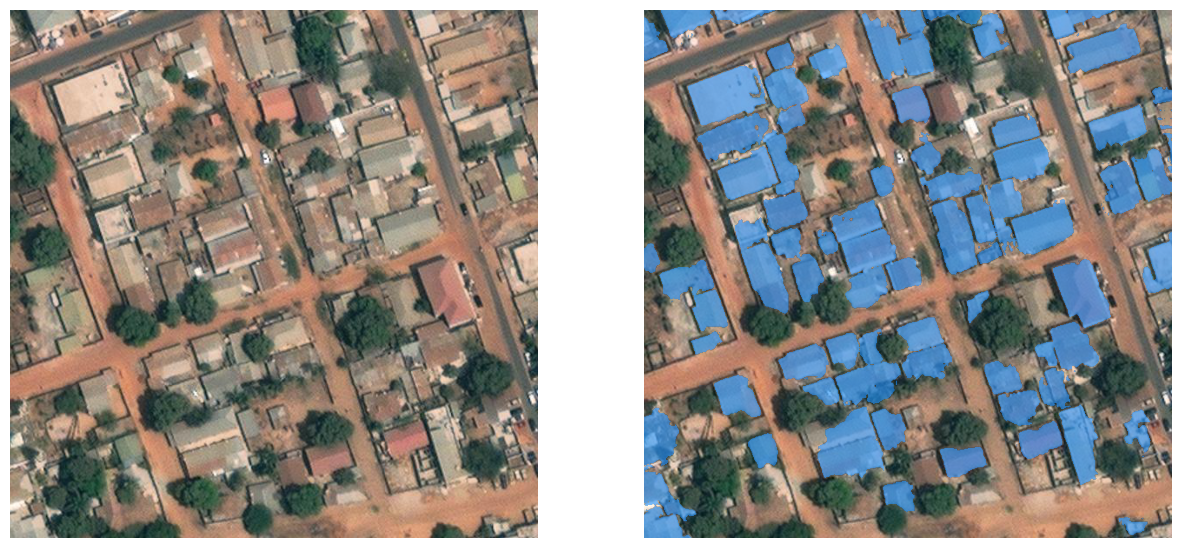

In [15]:
masks = torch.ge(predicted_logits[0, :, 0], 0).cpu().detach().numpy().any(axis=0)
plot_w_wo_masks_ESAM(sample_image_np, masks)

predicted_logits, predicted_iou = efficient_sam(
    sample_image_tensor[None, ...],
    input_points,
    input_labels,
)
# The masks are already sorted by their predicted IOUs.
# The first dimension is the batch size (we have a single image. so it is 1).
# The second dimension is the number of masks we want to generate (in this case, it is only 1)
# The third dimension is the number of candidate masks output by the model.
# For this demo we use the first mask.
mask = torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

masked_image_np = sample_image_np.copy().astype(np.uint8) * mask[:,:,None]
print(predicted_logits.shape)
plt.imshow(masked_image_np)
#Image.fromarray(masked_image_np).save("figs/examples/dogs_efficient_sam_mask.png")

input_points = torch.tensor([[[[200, 200], [300, 300]], [[400, 200], [500, 300]]]]) #[batch, boxes, top-left and bottom-right, 2 (x and y)]
input_labels = torch.tensor([[[2, 3], [2, 3]]])
print(input_points.shape)
print(input_labels.shape)

# Feed a few (x,y) points in the mask as input.
input_points = torch.tensor([[[[200, 200], [300, 300], [400, 200], [500, 300]]]]) #[batch, boxes, top-left and bottom-right, 2 (x and y)]
input_labels = torch.tensor([[[2, 3, 2, 3]]])
print(input_points.shape)
print(input_labels.shape)